In [3]:
%load_ext oct2py.ipython

The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Finite-State-Machine-Design" data-toc-modified-id="Finite-State-Machine-Design-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Finite State Machine Design</a></span></li><li><span><a href="#Model-Development-&amp;-Validation" data-toc-modified-id="Model-Development-&amp;-Validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Development &amp; Validation</a></span></li><li><span><a href="#Controller-Design" data-toc-modified-id="Controller-Design-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Controller Design</a></span></li><li><span><a href="#Controller-Validation-&amp;-Demonstration-Day-Performance-Assessment" data-toc-modified-id="Controller-Validation-&amp;-Demonstration-Day-Performance-Assessment-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Controller Validation &amp; Demonstration Day Performance Assessment</a></span></li><li><span><a href="#Next-Steps" data-toc-modified-id="Next-Steps-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Next Steps</a></span></li></ul></div>

## Finite State Machine Design
* State transition diagram and table

Following the requirements outlined in the Project 1 description, the following finite state machine was created. Essentially this FSM consists of five states: waiting, timing, forward (closed loop), forward (open loop), and turning. The user should be able to input an array of distances and angles and have the Zumo complete all segments of the track consisting of these distances and angles. The program will begin in the waiting state. In this state, the Zumo is not moving and is waiting for input from the user to move into the timing state. Upon a unique press of button C on the Zumo, it will enter the timing state. The Zumo will remain in this state for 1 second to allow adequate time for the user to remove their finger from the button. Once the 1 second is surpassed, the Zumo will first enter the forward (closed loop) state. In this state, the Zumo will drive forward utilizing both the position and velocity controllers to control it's speed as it approaches the gate. Once the desired distance is achieved, the Zumo will transition to the turning state. Upon transitioning from the forward (closed loop) state to the turning state, a counter will increment up 1, to signify that the Zumo has completed +1 of the forward driving segments. In the turning state, the yaw angle controller will turn the Zumo so as to achieve the desired angle. Once this desired angle is achieved, the Zumo will transition back to the forward (closed loop) state or into the forward (open loop) state if it is determined to be on the last leg of the track. Upon transitioning from the turning to the forward (closed loop) state a second counter will be incremented +1 to signify the completion of another turn. If the preset value of the first counter has been achieved (signifying that the Zumo is on the last leg of the track), the Zumo will transition from the turning state to the forward (open loop) state. In the forward (open loop) state, voltages determined from the Zumo model developed in Project 1 will be written to the Zumo's motor to travel the desired distance in a desired time. After the desired time has surpassed, the Zumo will then transition back into the waiting state where it will remain at rest until another input from the user. 

The following diagram shows the state transition diagram for this finite state machine:

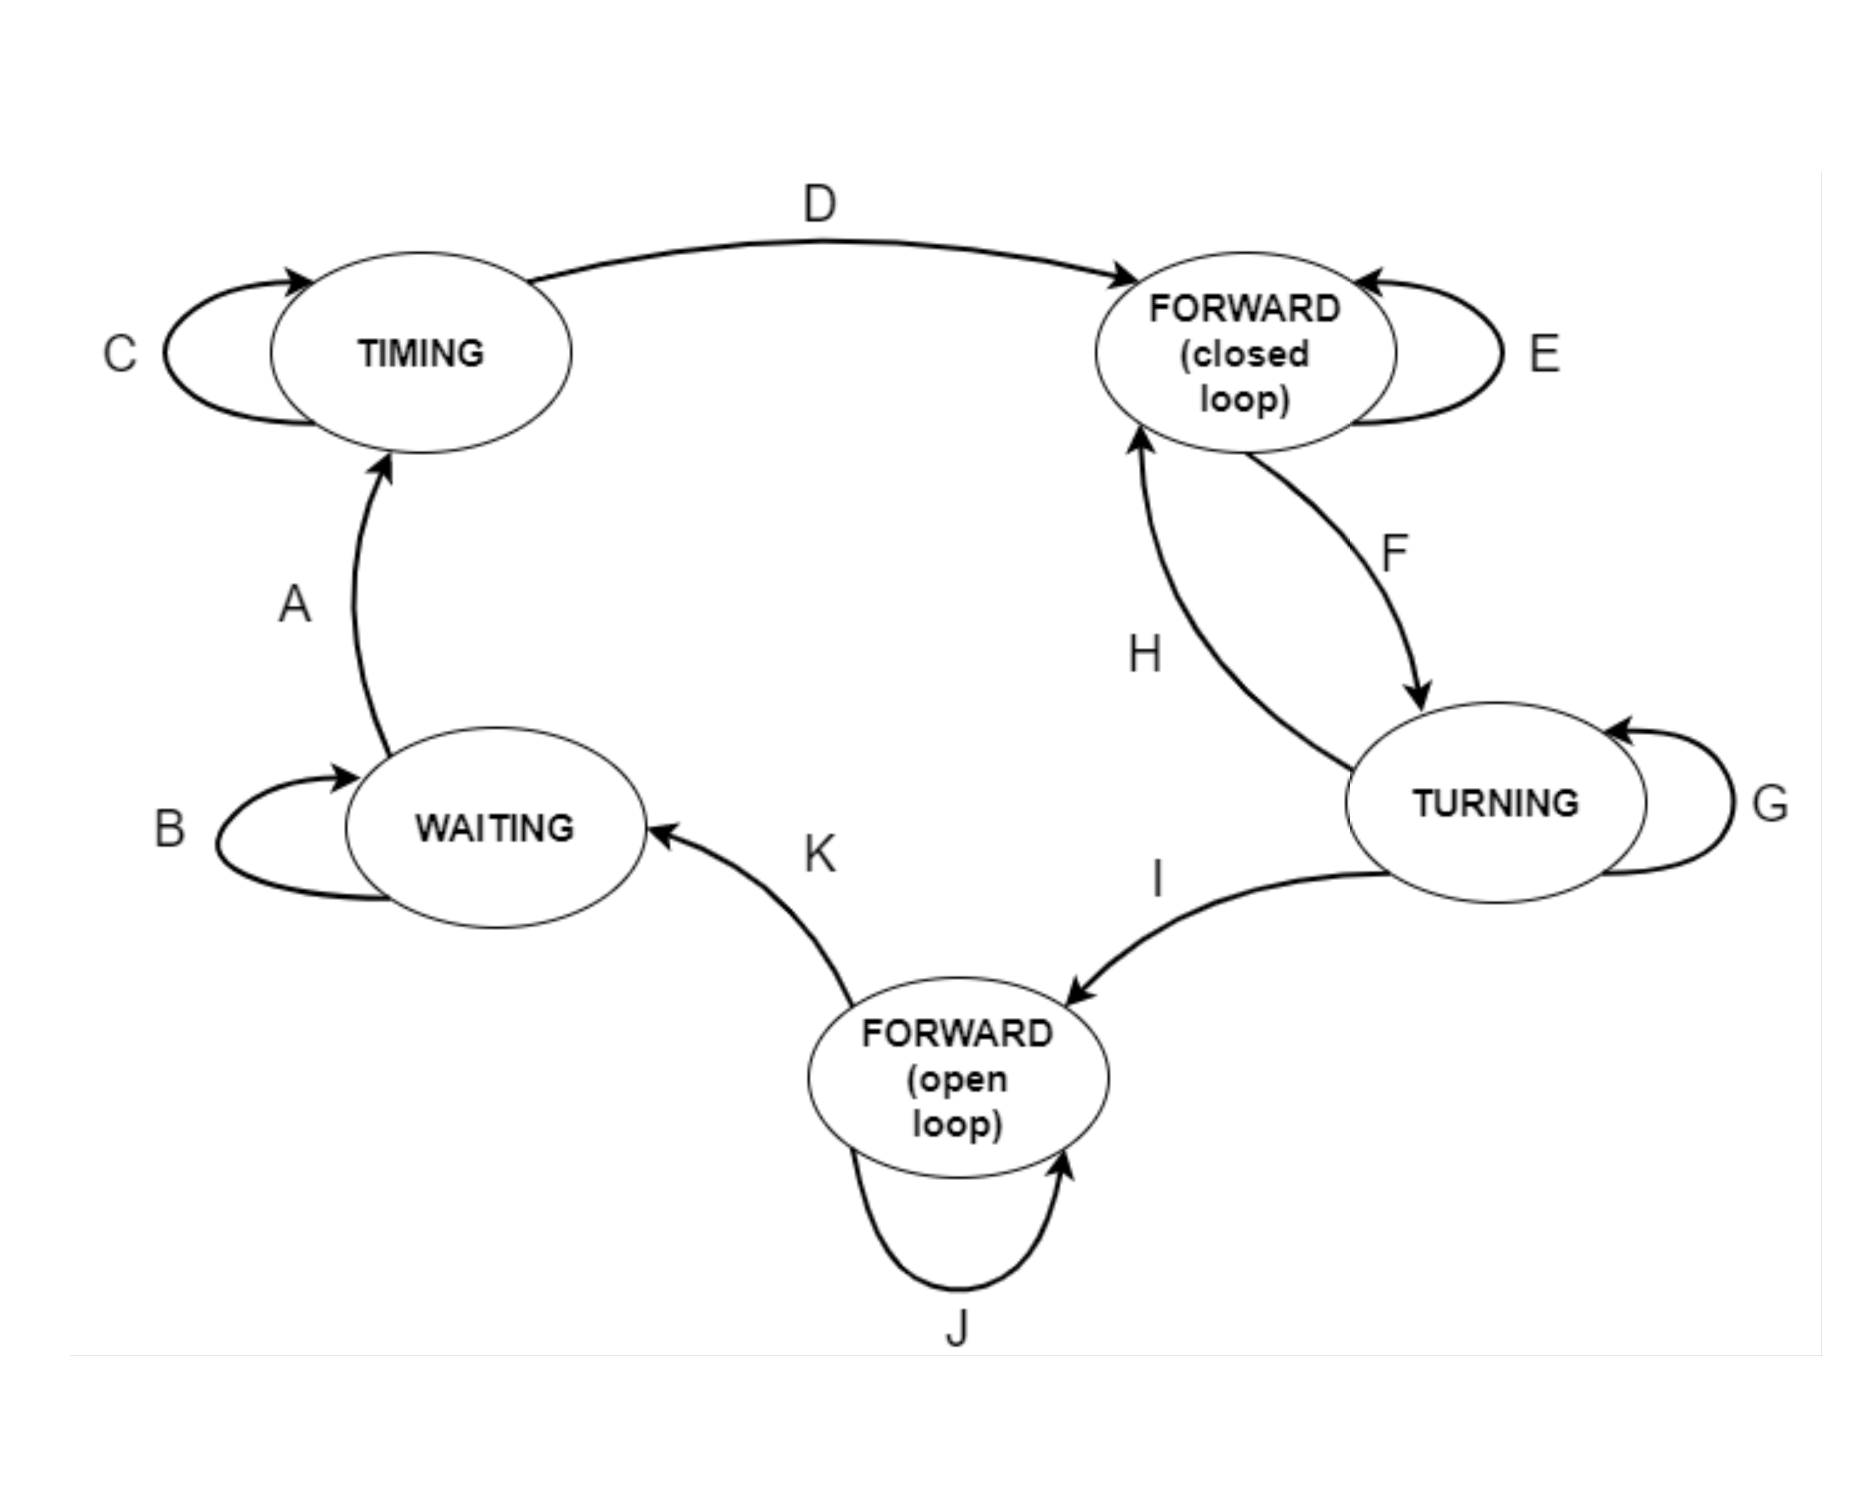

|Transition|Starting State|Transition Condition|Ending State|
|:---:|:---:|:---:|:---:|
|A|WAITING|$buttonPress$|TIMING|
|B|WAITING|$\overline{buttonPress}$|WAITING|
|C|TIMING|$\overline{TMR1}$|TIMING|
|D|TIMING|$TMR1$|FORWARD (closed loop)|
|E|FORWARD (closed loo)|errorPositionLeft > 0.015 + errorPositionRight > 0.015|FORWARD (closed loop)|
|F|FORWARD (closed loop)|errorPositionLeft <= 0.015 $\cdot$ errorPositionRight <= 0.015 $\cdot \overline{CNT2}$|TURNING|
|G|TURNING|$\overline{TMR2}$|TURNING|
|H|TURNING|$TMR2 \cdot \overline{CNT1}$|FORWARD|
|I|TURNING|$CNT1 \cdot TMR2$|FORWARD (open loop)|
|J|FORWARD (open loop)|$\overline{TMR2}$|FORWARD (open loop)|
|K|FORWARD (open loop)|$TMR2$|WAITING|

For the Arduino script of the FSM, please refer to Appendix A. It should be noted that the timer and counter FSMs are excluded for succinctness.

## Model Development & Validation
* Assumptions and Justification for all modeling choices.
* Plant validation plots

The model for the Zumo's motors (upon which the position and velocity controllers were built) was adopted from previous work on Project 1. The transfer function representing the model of the Zumo motor's angular speed to input voltage is given by:

$\frac{\Omega(s)}{V_s(s)} = \frac{K_t}{RJs + (K_t^2 + Rb)}$. 

For detailed information on the derivation of this model, please refer to the Project 1 report.

Validation of this model can be seen below:

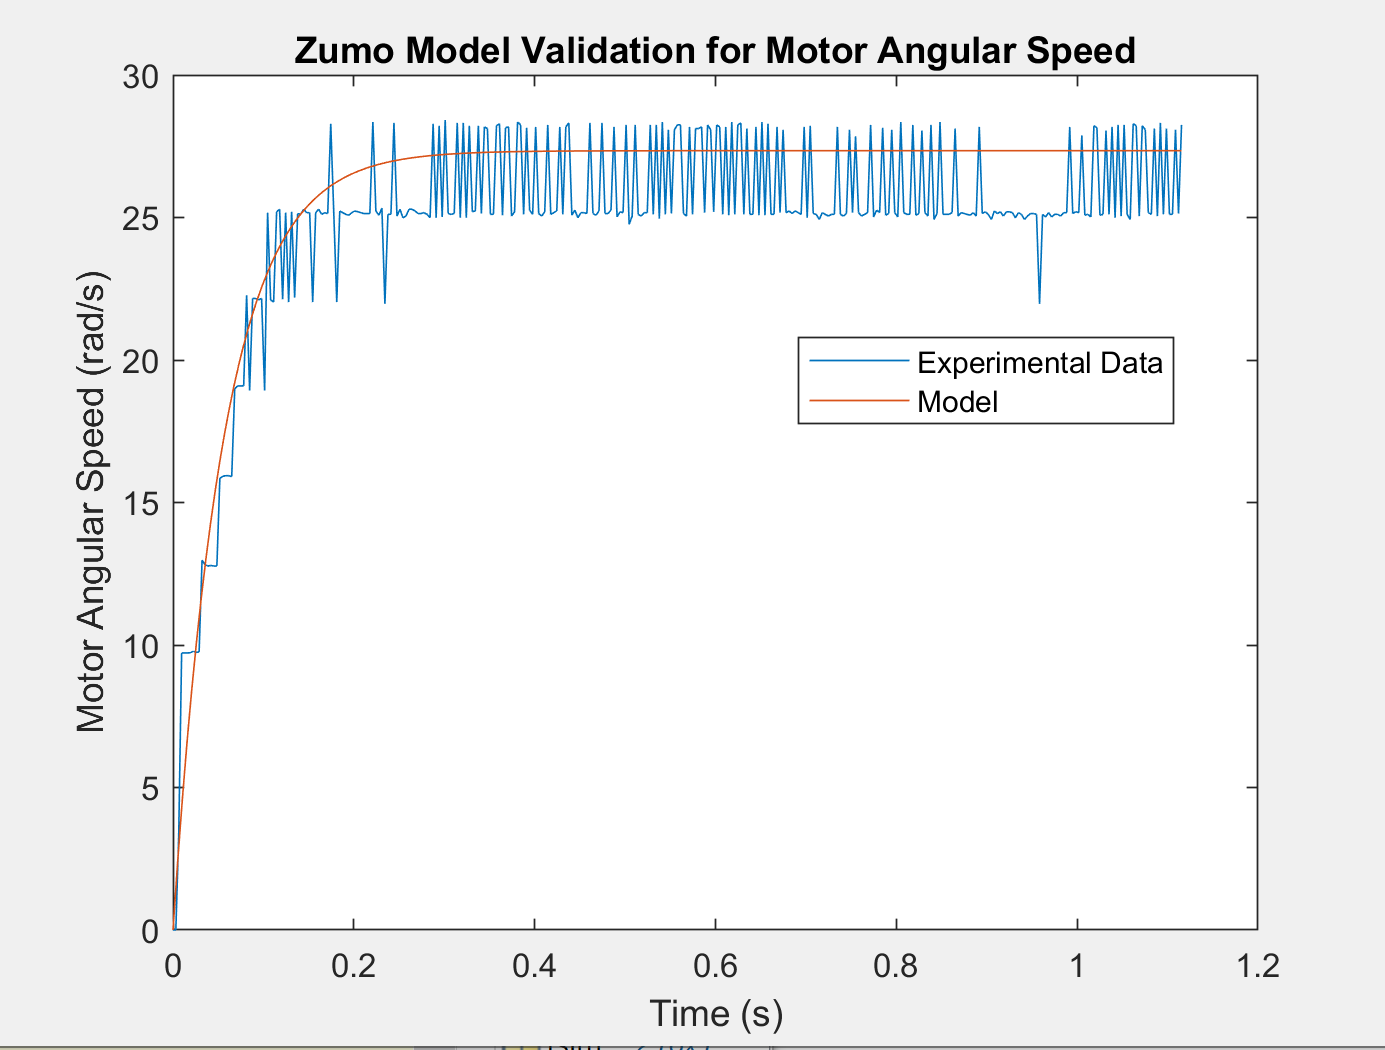

This plot shows the comparison of the derived model to experimental data with a input step voltage of 3.0 V. This plot shows the Zumo's motor angular velocity over time when given a step input voltage of 3.0 V. As can be clearly seen, the model is an accurrate predictor of the Zumo's transient and steady state angular speed. 

Angular position can be obtained by integrating the angular speed transfer function (or multiplying by 1/s). 

The model developed for the purposes of this project was the Zumo's turning behavior. Specifically a model relating input voltage and yaw angular speed was determined. Unlike the previously presented model, the model of the Zumo's yaw angular speed was derived numerically. From preliminary data sampling, this model was determined to be first order, thus having the general form of: $P(s) = \frac{A}{s+a}$, where $A$ and $a$ are numerically determined coefficients. 

In order to determine the coeffients $A$ and $a$, data was sampled by inputting a given voltage and recording the turning rate of the Zumo. This data set was then utilized to determine numerical values for this transfer function's coefficients. 

First, the coefficient $a$ represents the eigenvalue of the system and since we know that $\tau = -\frac{1}{p}$ where p is the system's pole, a numerical value for $a$ was determined: 

$\tau = -\frac{1}{p} = -\frac{1}{-a} = \frac{1}{a}$ 

From MATLAB calculations based on the collected dataset:

$\tau = 0.0340 s = \frac{1}{a}$ ---> $a = 29.422$

Next, the coefficient $A$ represents the steady state gain of the system and was determined using the final value theorem: 

$\dot{\psi}_{ss} = \lim_{s \to 0} sY(s) = \lim_{s \to 0} s\cdot \frac{U(s)}{s} \frac{A}{s+a}$ --> $\dot{\psi}_{ss} = \frac{VsA}{s+a}$. 

From MATLAB calculations based on the collected dataset: 

$209.8973$ rad/s $= \frac{1.83 V\cdot A}{29.422}$ ---> $A = 3374.6$

Thus the final transfer function for the model of the Zumo's yaw angular speed with input voltage is:

$\frac{\dot{\psi}(s)}{V_s(s)} = \frac{3375}{s + 29.42} $

The plot below depicts the validation test for the yaw angular velocity model:

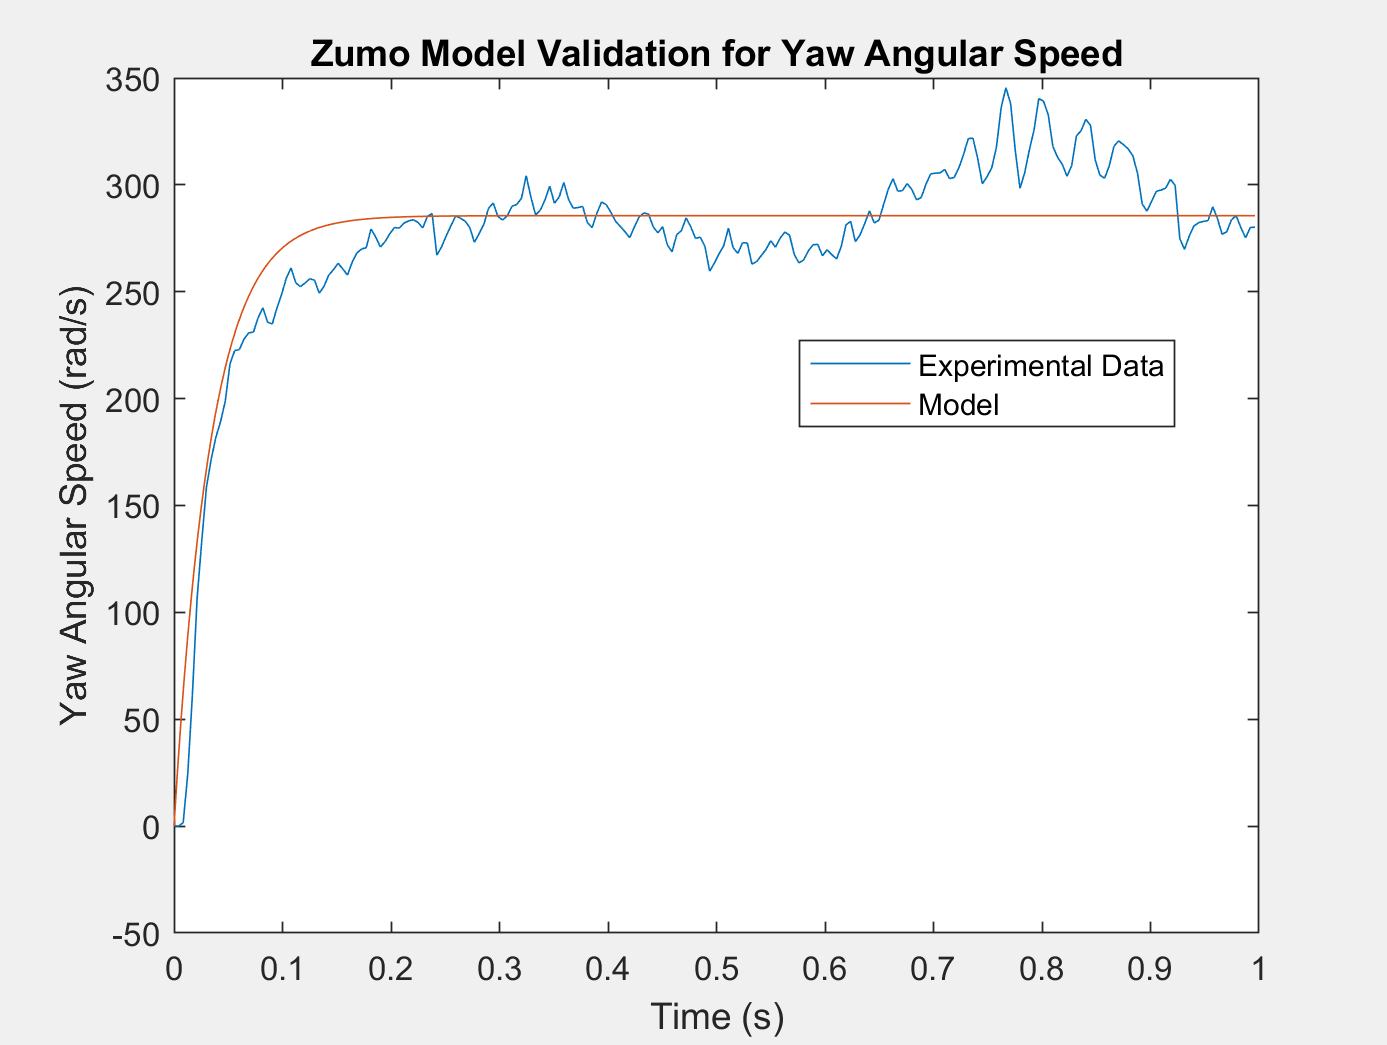

This plot shows the comparison of the derived model to experimental data with a input step voltage of 2.5 V. This plot shows the Zumo's yaw angular speed over time when given a step input voltage of 2.5 V. As can be clearly seen, the model is an accurrate predictor of the Zumo's transient and steady state yaw angular speed.

## Controller Design
* List of controllers that are active by state
* Assumptions and justifications for each controller type
* Process to determine desired behavior (design goal) for each controller
* Process, including all steps (hand calcs or Octave code), for each controller design (root locus, angle deficiency, etc.)
* Final controller gains for each controller

For this project I utilized three controllers: a position controller, a velocity controller, and a yaw angle controller. Since the position and velocity controllers work in tandem, a nested position-velocity controller (in which the velocity controller was nested inside the position controller) was chosen. A separate yaw angle controller was also developed. The position-velocity nested controller was only active in the forward (closed loop) state, in which the Zumo was driving forward under closed-loop control during all segments of the track except the final. The angle controller was only active during the turning state in which the Zumo was turning between each segment of the track. 

Starting with the nested-position velocity controller, the block diagram that outlines this controller is shown below:

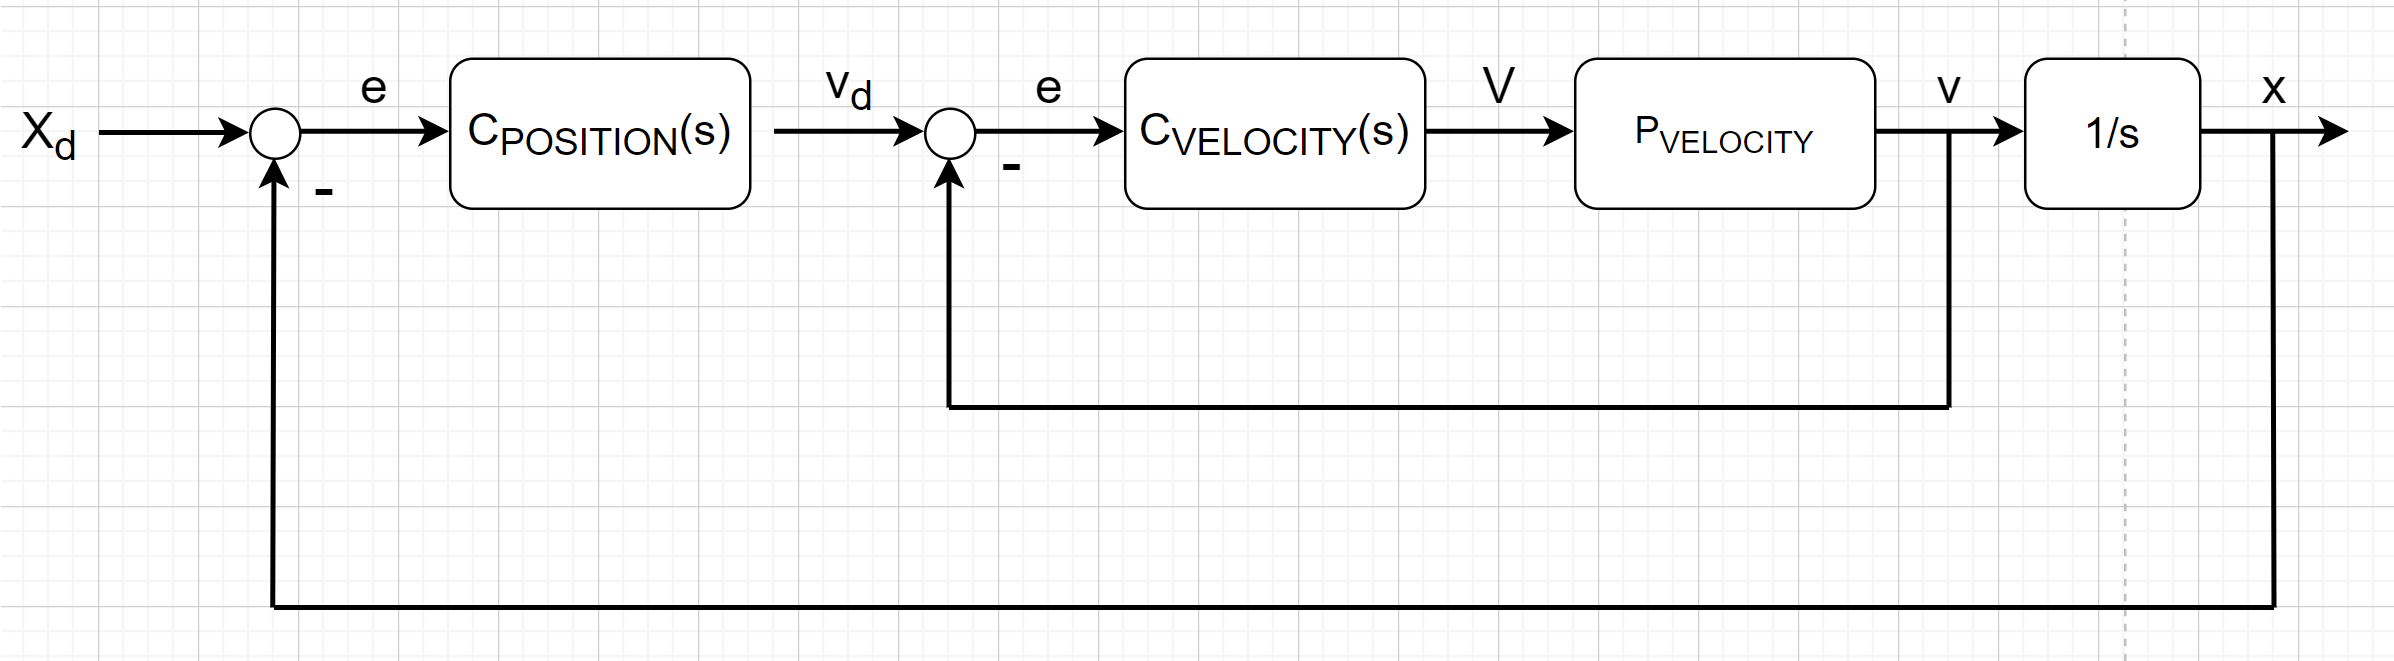

It should be noted that this block diagram setup neglects the transfer function $H(s)$, as it was assumed to be 1 for all controllers developed for this project.

Starting with the nested velocity controller, PI control was chosen as to be able to achieve zero steady state error. This type of controller would add a zero at some value $z_1$ and a pole at the origin. The transfer function for velocity under PI control takes the form:

$GH_{velocity} = \frac{K_t(s+z_1)}{RJs^2 + (K_t^2 + Rb)s} = \frac{0.06622(s+z_1)}{0.000409s^2 + 0.007688s}$

In order to determine the zero, a desired eigenvalue must be determined. In this case, I chose a desired settling time of $t_s = 0.15 s$ and a damping ratio of $\zeta = 0.707$. Since $t_s = \frac{4}{\zeta \omega_n}$, the desired natural frequency ($\omega_n$) was determined to be 37.7 rad/s. Once the desired eigenvalue was determined, the zero was found utilizing angle deficiency method:

$\Sigma (< poles) - \Sigma (< zeros) = \pm 180$

$(< p1 + < p2) - (< z1) = \pm 180$

The Octave cell below shows the calculation for determining the angle of the velocity controller's zero:


In [5]:
%%octave

% setting up plant transfer function
Kt = 0.066224663383711;
R = 3.75;
J = 1.090662815697082E-4;
b = 8.805942159746549E-4;

s = tf('s');
P = Kt/(R*J*s + (Kt^2 + R*b));

tsd = 0.15; % desired 2% settling time 
zetad = 0.707; % desired damping ratio for the first order piece
wnd = 4/(tsd*zetad); % desired natural frequency for the first order piece
sd1 = -(zetad*wnd) + wnd*sqrt(1-zetad^2)*1j;
sd2 = -(zetad*wnd) - wnd*sqrt(1-zetad^2)*1j;

ang_p1 = atan2d(wnd*sqrt(1-zetad^2),-zetad*wnd); % angle from pole at origin to target eigenvalue
ang_p2 = atan2d(wnd*sqrt(1-zetad^2),-zetad*wnd+((Kt^2 + R*b)/(R*J))); % angle from pole at a to target eigenvalue
ang_z_vel = -180+ang_p1+ang_p2 % angle from zeroto target eigenvalue

ang_z_vel =  61.429

Using basic trigonemtric relationships, a value for the zero can be determined:

In [6]:
%%octave

d = (wnd*sqrt(1-zetad^2))/(tand(ang_z_vel));
z_vel = zetad*wnd + d % zero

z_vel =  41.193

Therefore, the transfer function for velocity under PI-control becomes:

$GH_{velocity} = \frac{K_t(s+z_1)}{RJs^2 + (K_t^2 + Rb)s} = \frac{0.06622s+2.728}{0.000409s^2 + 0.007688s}$

The root locus for the velocity PI controller is shown below with desired eigenvalues emphasized with large red circles:

Transfer function 'GH_vel' from input 'u1' to output ...

          0.06622 s + 2.728

 y1:  -------------------------

      0.000409 s^2 + 0.007688 s

Continuous-time model.

                                      Root Locus of GHvel

                   |   *         *         *         *         *        *

                30 |-+*****************************+----------$$$$$$------+*

                   |   *         *         *       |###?###lo$$s   G$     |

                20 |-+*****************************|   B   open loop poles|*

                   |   *         *         *       +---F---zeros-----$----+

                   |   *         *         *         *     $   *      $ *

                10 |-+*************************************$**********$*****

                   |   *         *         *         *    $$   *      $ *

                 0 |**####################################$$$$$$F****B$$B***

                   |   *         *         *         *    #    *      # *

                   |   *         *         *         *    ##   *      # *

               -10 |-+*************************************#**********#*****

                   |   *         *         *         *     #   *      # *

                   |   *         *         *         *     ##  *     #  *

               -20 |-+**************************************#*******##******

                   |   *         *         *         *       ##*   G#   *

               -30 |-+*+*********+*********+*********+********######****+***

                   |--------------------------------------------------------

                     -250      -200      -150      -100       -50       0

                               Real Axis     gain = [0, 1.76701]

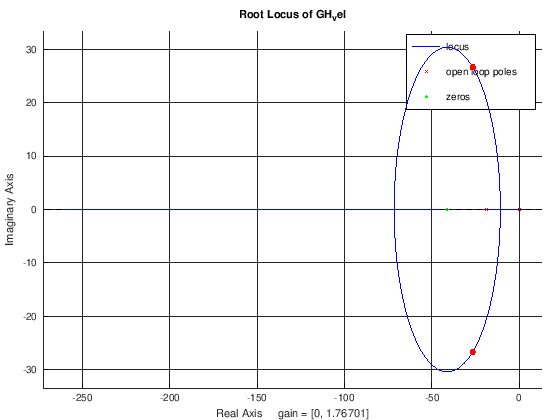

In [7]:
%%octave

GH_vel = ((s+z_vel)/s)*P
figure()
hold on;
rlocus(GH_vel)
plot(real(sd1),imag(sd1),'r.','MarkerSize',15)
plot(real(sd2),imag(sd2),'r.','MarkerSize',15)
hold off;

Once a value for the zero is determined, the overall controller gain can be determined using the magnitude criterion where: $|\frac{-1}{K}| = |G(s)H(s)|$. Once the overall controller gain is determined, values for the proportional and integral controller gains can be determied through the following relationships:

$K = K_{sum}K_p$

$z = \frac{K_i}{K_p}$

Calculations for the overall controller gain, as well as the proportional and integral gains for the velocity controller is shown in the Octave cell below:

In [8]:
%%octave

mag_GH_at_sd = abs((0.06622*sd1 + 2.728)/(0.000409*sd1^2 + 0.007688*sd1));
K_vel = 1/(mag_GH_at_sd)
Ksum = 1;
Kp_vel = K_vel/Ksum
Ki_vel = Kp_vel*z_vel

K_vel =  0.21330

Kp_vel =  0.21330

Ki_vel =  8.7864

The next controller developed was the position controller inside which the PI-velocity controller would be nested (refer to above block diagram). The plant transfer function for this controller would thus be the integrated closed loop transfer function for the PI-velocity controller: 

$ P(s)_{position} = GH_{velocity}\cdot \frac{1}{s} = \frac{0.06622s+2.728}{0.000409s^3 + 0.007688s^2}$

Since this plant transfer function has a free integrator, PD control was chosen as zero steady state error is able to be achieved due to the presence of the pole at the origin. This controller would thus only add a zero to the plant transfer function. The transfer function for position under PD control takes the form:

$GH_{position} = \frac{K_t(s+z_1)(s+z_2)}{RJs^3 + (K_t^2 + Rb)s^2} = \frac{(0.06622s + 2.728)(s+z_2)}{0.000409s^3 + 0.007688s^2}$

The same desired eigenvalue was used for the position controller as well as the velocity controller. Determination of the position controller zero as well as its respective gains were determined following the same procedure previously outlined. Calculations and the root locus of the position controller transfer function can be seen in the Octave cell below:


In [10]:
%%octave

ang_p1 = atan2d(wnd*sqrt(1-zetad^2),-zetad*wnd); % angle from pole at origin to target eigenvalue
ang_p2 = atan2d(wnd*sqrt(1-zetad^2),-zetad*wnd+((Kt^2 + R*b)/(R*J))); % angle from pole at a to target eigenvalue
ang_p3 = atan2d(wnd*sqrt(1-zetad^2),-zetad*wnd);
ang_z_vel = 180;
ang_z_pos = -180+ang_p1+ang_p2+ang_p3-ang_z_vel; % angle from zeroto target eigenvalue
d = (wnd*sqrt(1-zetad^2))/(tand(ang_z_pos));
z_pos = zetad*wnd + d % zero

% plotting RL...
GH_pos = (s+z_pos)*GH_vel*(1/s);

mag_GH_at_sd = abs((0.06622*sd1^2 + 10.49*sd1 + 319.7)/(0.000409*sd1^3 + 0.007688*sd1^2));
K_pos = 1/(mag_GH_at_sd)
Ksum = 1;
Kd_pos = K_pos/Ksum
Kp_pos = Kd_pos*z_pos

z_pos =  117.18

K_pos =  0.085234

Kd_pos =  0.085234

Kp_pos =  9.9880

Therefore, the transfer function for position under PD-control becomes:

$GH_{position} = \frac{K_t(s+z_1)(s+z_2)}{RJs^3 + (K_t^2 + Rb)s^2} = \frac{0.06622s^2 + 10.49s + 319.7}{0.000409s^3 + 0.007688s^2}$

The root locus for the position PD controller is shown below with desired eigenvalues emphasized with large red circles:

                                      Root Locus of GHpos

                    |   #         #        #         #         #        #

                    |   #         #        #       +------------%%%%%%----+

                    |   #         #        #       |###?###locu%%    %%   |

                100 |-+############################|   B   open loop poles|#

                    |   #         #        #       +---F---zeros--------%-+

                    |   #         #        #         #       % #        %

                 50 |-+######################################%##########%###

                    |   #         #        #         #      %  #       G%%

                  0 |**%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%$$$$$$F**F#B***

                    |   #         #        #         #      $  #        $

                    |   #         #        #         #      $  #       G$$

                -50 |-+######################################$##########$###

                    |   #         #        #         #       $ #        $

                    |   #         #        #         #       $$#        $

               -100 |-+#######################################$$#######$####

                    |   #         #        #         #         $$    $$ #

                    |   +         +        +         +         +$$$$$$  +

                    |-------------------------------------------------------

                      -1000     -800     -600      -400      -200       0

                               Real Axis     gain = [0, 7.33094]

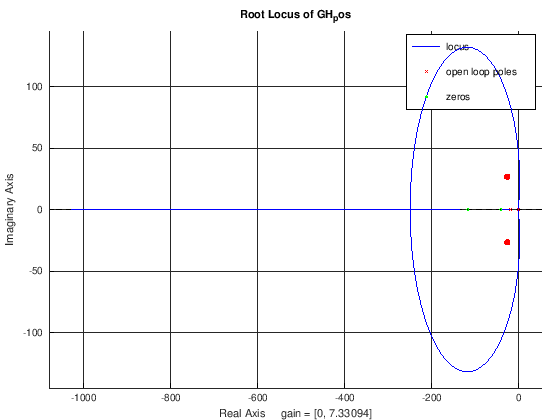

In [11]:
%%octave

figure()
hold on;
rlocus(GH_pos)
plot(real(sd1),imag(sd1),'r.','MarkerSize',15)
plot(real(sd2),imag(sd2),'r.','MarkerSize',15)
hold off;

As can be seen, this root locus does not exactly pass through the desired eigenvalue. However, this desired eigenvalue was determined somewhat arbitrarily and it is thus not imperative that the root locus pass between this specific eigenvalue, more so that it comes somewhat close. It can also be seen that the root locus starts unstable before crossing over the vertical axis and becoming stable. Thus, the critical gain was checked as to avoid falling within this instability region.

The critical gain, the gain at which the root locus crosses over the vertical axis, can be calculated using Step 6 of Root Locus sketching:

$ 1 + KGH = 0$ --> $1 + K\cdot \frac{0.06622s^2 + 10.49s + 319.7}{0.000409s^3 + 0.007688s^2} = 0$ 

Therefore,

$0.00409s^3 + 0.007688s^2 + K(0.06622s^2 + 10.49s + 319.7) = 0$

Substituting in $s = j\omega_c$ and $K = K_c$, the critical frequency and gain can be determined:

$ imaginary: j(-0.000409\omega_c^3 + 10.49K_c\omega_c) = 0$

$ real: -0.007688\omega_c^2 - 0.06622\omega_c^2 + 319.7 = 0$

Solving this system of equations, it is found that the critical gain and frequency are 0.0721 and 43.0 rad/s, respectively. Since the gain calculated above for the position controller is K = 0.085234 (thus greater than the critical gain), this controller system is stable. 

The last controller developed was the yaw angle controller that was separate from the nested position-velocity controller. The block diagram for this controller can be seen below:

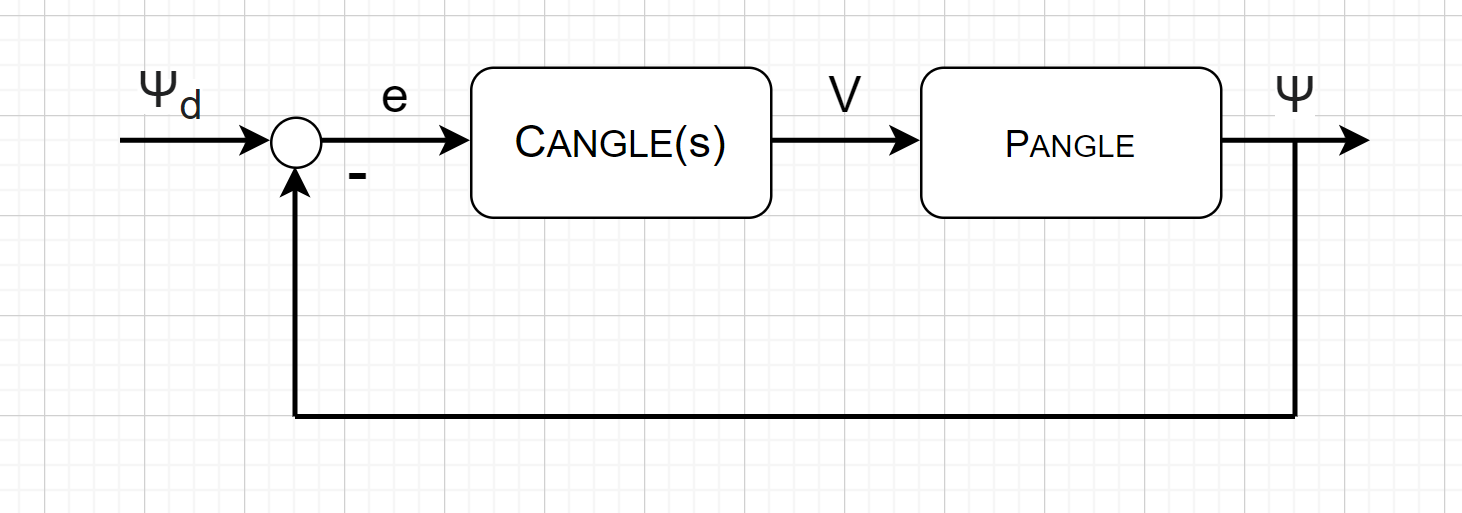

Again, it should be noted that this block diagram setup neglects the transfer function $H(s)$, as it was assumed to be 1 for all controllers developed for this project.

The plant transfer function for yaw angle was determined by integrating the yaw rate transfer function developed above in the Model Development and Validation section:

$P_{angle}(s) = \frac{\dot{\psi}(s)}{V_s(s)} \cdot \frac{1}{s} = \frac{3375}{s + 29.42} \cdot \frac{1}{s} = \frac{3375}{s^2 + 29.42s}$

Since this plant transfer function has a free integrator, PD control was chosen as zero steady state error is able to be achieved due to the presence of the pole at the origin. This controller would thus only add a zero to the plant transfer function. The transfer function for yaw angle under PD control takes the form:

$GH_{angle} = \frac{3375(s+z_3)}{s^2 + 29.42s}$

In order to determine the zero, a desired eigenvalue must be determined. In this case, I chose a desired settling time of $t_s = 0.2 s$ and a damping ratio of $\zeta = 0.9$. Since $t_s = \frac{4}{\zeta \omega_n}$, the desired natural frequency ($\omega_n$) was determined to be 22.2 rad/s. Determination of the angle controller zero as well as its respective gains were determined following the same procedure previously outlined. Calculations and the root locus of the angle controller transfer function can be seen in the Octave cell below:

In [12]:
%%octave
% setting up plant transfer function
a = 29.422148993764893;
A = 3.374660422103576e+03;

s = tf('s');
Pyaw = (A/(s+a))*(1/s);


tsd = 0.2; % desired 2% settling time 
zetad = 0.9; % desired damping ratio for the first order piece
wnd = 4/(tsd*zetad); % desired natural frequency for the first order piece
sd1 = -(zetad*wnd) + wnd*sqrt(1-zetad^2)*1j;
sd2 = -(zetad*wnd) - wnd*sqrt(1-zetad^2)*1j;

ang_p1 = atan2d(wnd*sqrt(1-zetad^2),-zetad*wnd); % angle from pole at origin to target eigenvalue
ang_p2 = atan2d(wnd*sqrt(1-zetad^2),-zetad*wnd+a); % angle from pole at a to target eigenvalue
ang_z_angle = -180+ang_p1+ang_p2; % angle from zero to target eigenvalue
d = (wnd*sqrt(1-zetad^2))/(tand(ang_z_angle));
z_angle = zetad*wnd + d % zero

GH_angle = (s+z_angle)*Pyaw

mag_GH_at_sd = abs((3375*sd1+1.575E5)/(sd1^2+29.42*sd1));
K_angle = 1/(mag_GH_at_sd)
Ksum = 1;
Kd_angle = K_angle/Ksum
Kp_angle = Kd_angle*z_angle

z_angle =  46.685

Transfer function 'GH_angle' from input 'u1' to output ...

      3375 s + 1.575e+05

 y1:  ------------------

        s^2 + 29.42 s

Continuous-time model.

K_angle =  0.0031357

Kd_angle =  0.0031357

Kp_angle =  0.14639

Therefore, the transfer function for angle under PD-control becomes:

$GH_{angle} = \frac{3375s+1.575E5}{s^2+29.42}$

The root locus for the angle PD controller is shown below with desired eigenvalues emphasized with large red circles:

                                     Root Locus of GHangle

                30 |-+******************************************************

                   |   *         *         *       +---------$$$$$$-------+

                   |   *         *         *       |###?###l$$us  $$      |

                20 |-+*****************************|   B   open loop poles|*

                   |   *         *         *       +---F---zeros----$-----+

                   |   *         *         *         *    $    *    $   *

                10 |-+************************************$*********$G******

                   |   *         *         *         *    $    *     $  *

                 0 |**####################################$$$$$F***B#$$$B***

                   |   *         *         *         *    #    *     #  *

                   |   *         *         *         *    #    *     #  *

               -10 |-+************************************#*********#G******

                   |   *         *         *         *    #    *    #   *

                   |   *         *         *         *     #   *    #   *

               -20 |-+*************************************##******#********

                   |   *         *         *         *      ## *  ##    *

                   |   +         +         +         +       ######     +

               -30 |--------------------------------------------------------

                     -250      -200      -150      -100       -50       0

                              Real Axis     gain = [0, 0.0832061]

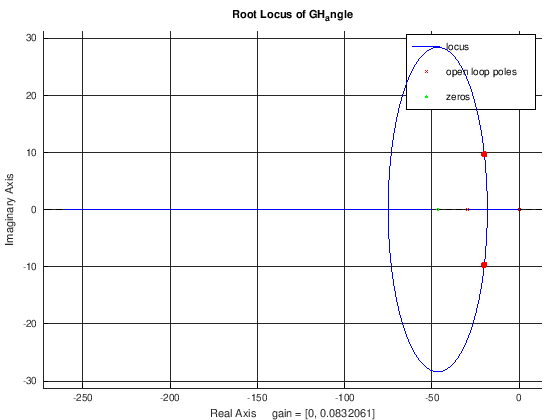

In [13]:
%%octave

figure()
hold on;
rlocus(GH_angle)
plot(real(sd1),imag(sd1),'r.','MarkerSize',15)
plot(real(sd2),imag(sd2),'r.','MarkerSize',15)
hold off;

## Controller Validation & Demonstration Day Performance Assessment
 
* Comparison of predicted and measured step responses for each controller. These must be of appropriate magnitude to make a meaningful comparison.
* Quantative assessment of demonstration day performance. Any progress made after needs to be reported in Next Steps
* Physical arguments for any variations between predictions and achieved performance.

Controller validation for the nested position-velocity controller would be difficult as it require the separation the two to validate both controller models. It may also involve avoiding the nonlinearity of the fact that the batteries are not an ideal power source. Thus, validation for the position-velocity controller took the form of checking that the Zumo is able to go a set distance with a certain desired speed. This was accomplished by simulating the first leg of the track in which the Zumo had to be able to drive at an appropriate speed as to make it through the gate in a timely manner. An example of such test can be seen in the video linked below:

https://photos.app.goo.gl/1JbsmbyPB6FcwKw57

The angle controller was able to be tested separately as it was an isolated and separate entity. Below, a plot of a a validation test is shown where the Zumo was given a step desired angle of $45^{\circ}$:

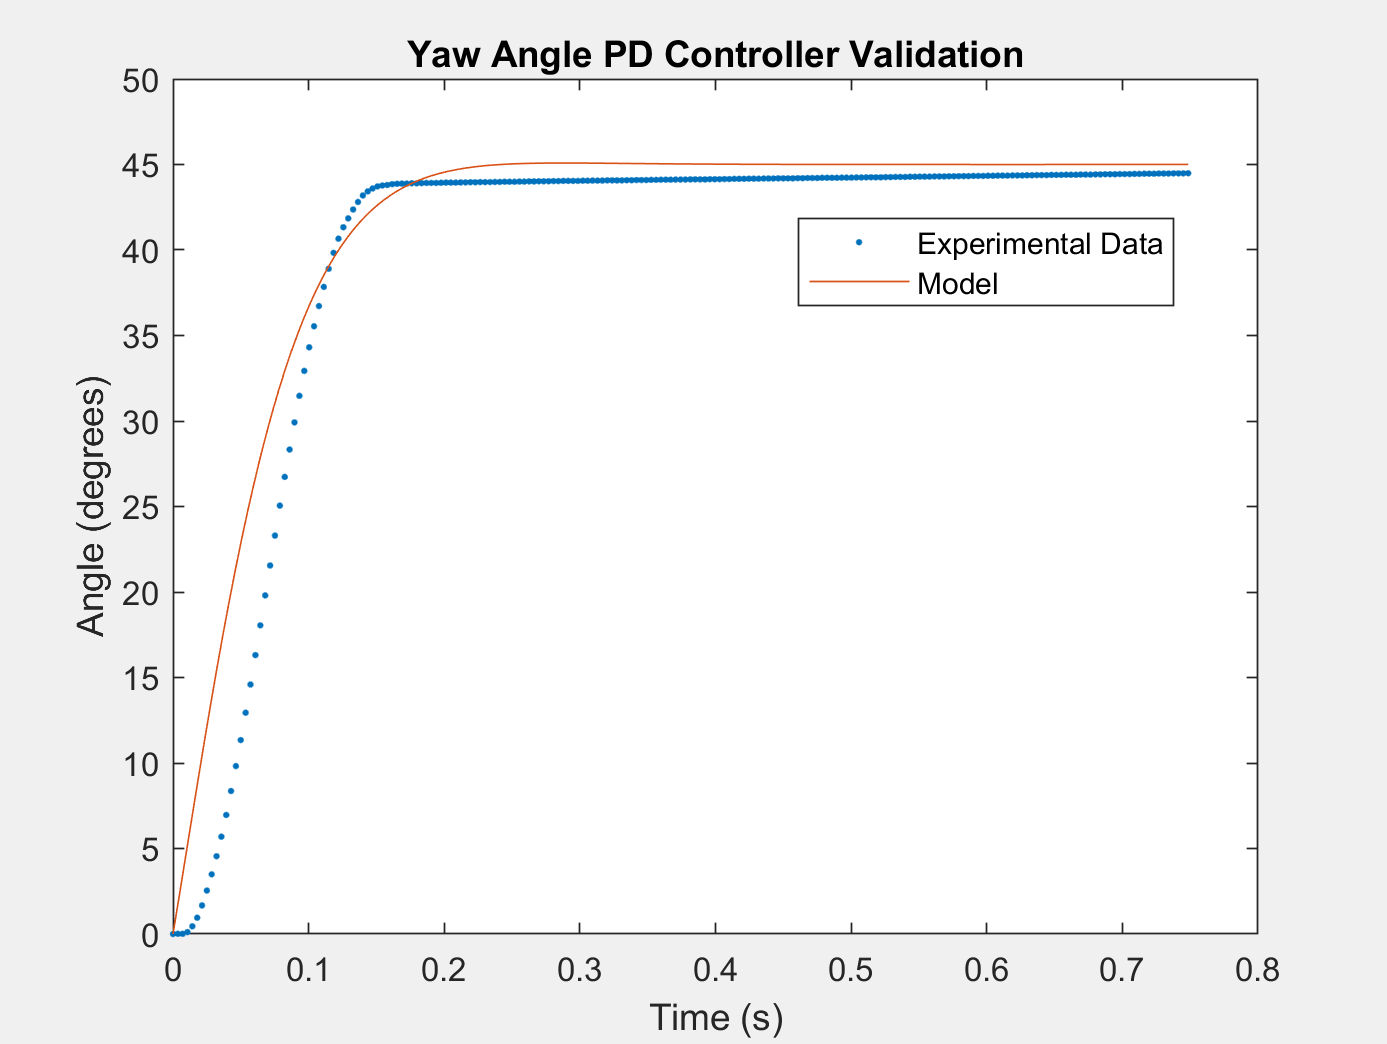

As can be seen from the plot, the controller predicts the steady state behavior with extreme accuracy. The transient response is not as tightly accurate. This is most likely due to the fact that the Zumo was starting from rest, thus it experiences Coulomb resistance friction when first beginning to move. This nonlinearity is not included in the controller model, thus the behavior between the model and the experimental data differs slightly in the beginning, but appears to correct as time passes. 

On test day, the Zumo specifically had issues with accurate turning when it came to larger angles. This behavior can be seen in the video of the actual test run linked below:

https://photos.app.goo.gl/KF9wvMZCKTrmwim26

Overall, this inaccuracy in angle turning was the main factor that contributed to the Zumo landing off-center on or missing the targets all together. Coming out of test day, the angle controller was the main area of improvement in order to upgrade the performance of the Zumo. 

## Next Steps
* Description of any changes *you have made* (as opposed to ones you could make or plan to make) after demonstration day and tangible proof of improvement as a result (this can be a simulation, a video, or data)

For consistancy purposes, yaw rate data to develop the yaw rate model was retaken using the same surface upon which testing was completed. Although the differences were not very pronounced, the revised yaw rate model and subsequent angle controller design steps and calculations are outlined below.

Using the same process above, the model transfer function relating yaw rate to input voltage was determined to be:

$\frac{\dot{\psi}(s)}{V_s(s)} = \frac{3064}{s + 23.19} $

and the comparison of the model to experimental data can be seen below:

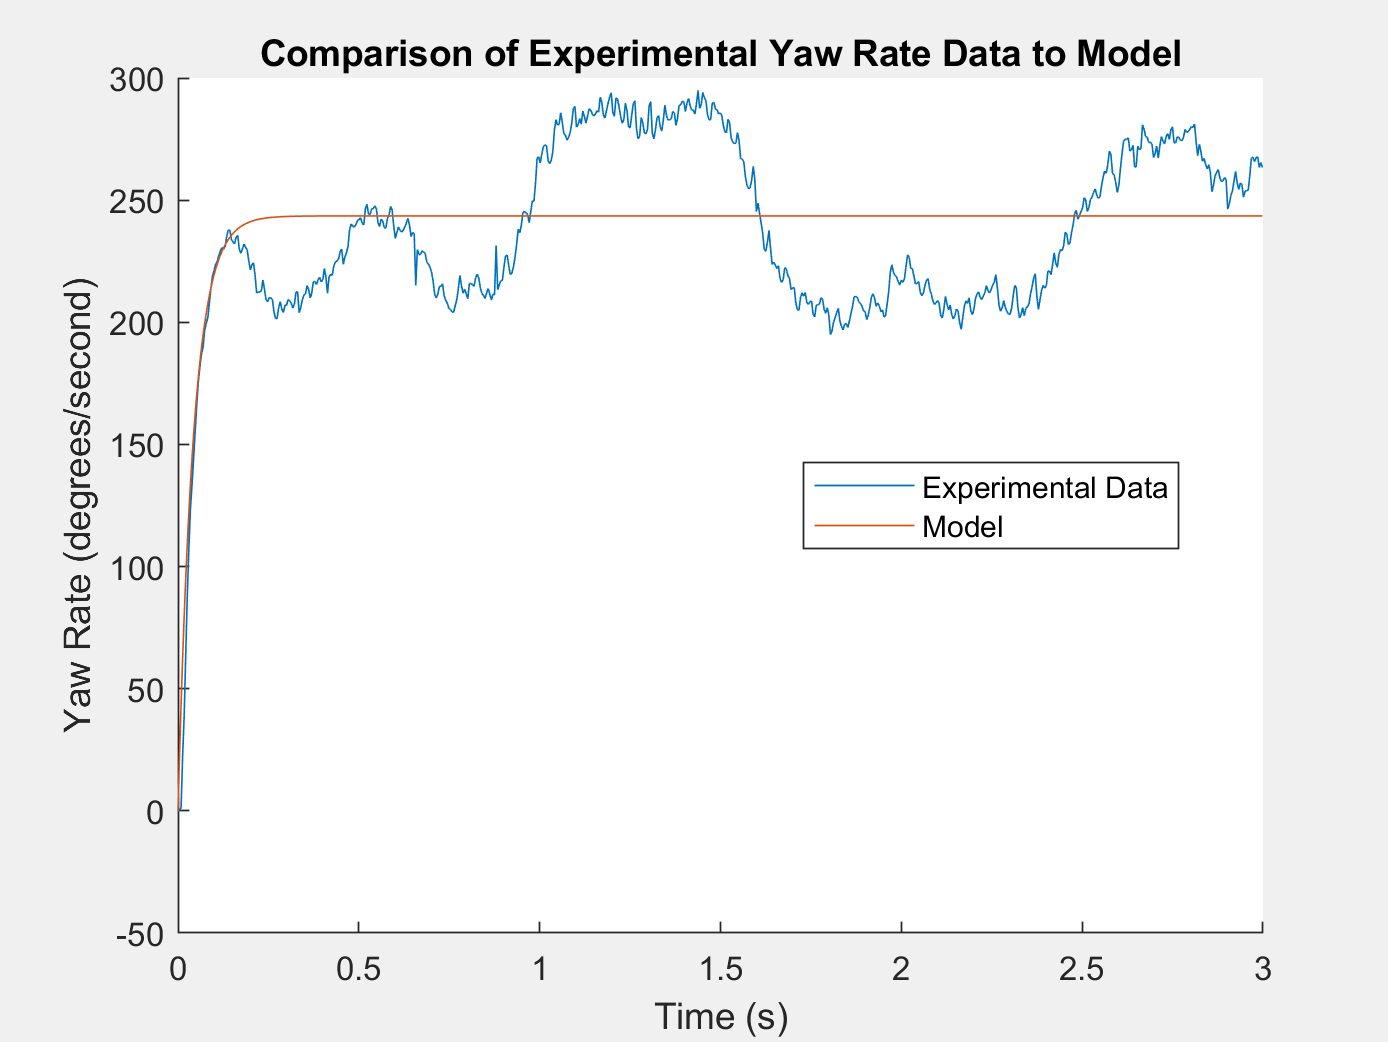

The same procedure outlined above was followed to determine the angle controller zero as well as the proportional and derivative gains. These new angle controller gains were: $K_p = 0.2197$ and $K_d = 0.0078$. However, upon testing with these new gains, the same issues were still occurring.  

The next obstacle to tackle was to determine why the angle controller was not producing accurate results and what needed to be adjusted. The two main options were either: error in the way the yaw angle was being calculated in the FSM or an error within the angle controller design itself. 

Through some preliminary testing, it was determined that the Zumo would typically have some steady state error when turning. Thus, the angle the Zumo was reporting was indeed the actual angle it had turned, but it was a good amount off from the desired angle. 

Thus I was able to conclude that the issue lied within the actual controller design of the angle controller. As can be seen in the yaw angle controller validation, Coulomb friction has the potential to significantly influence the Zumo's transient turning behavior. 

It was determined that the current angle controller implemented was not aggressive enough to overcome Coulomb friction effects when the error between the Zumo's angle and the desired angle is very small. 

The next step I took was the actually determine the required voltage the Zumo needs to be supplied in order to just overcome Coulomb friction. From exploratory testing, this voltage was determined to be approximately 1.5 V. This was the minimum voltage that needed to be supplied in order to have the Zumo accurately turn a full $180^{\circ}$ without stopping due to Coulomb friction effects. Knowing this minimum required voltage and the error in angle I would be satisfied with, a rough estimate of the proportional gain for the angle controller was able to be determined. These calculations can be seen below:

From the yaw angle controller block diagram: $V = K_p\cdot error$

Therefore, 3% error was chosen and evaluated at the Zumo's largest turn of $180^{\circ}$:

$1.5 = K_p(0.03)(180^{\circ})$ --> $K_{p,min} = 0.277 \approx 0.3$

Currently, the proportional gain for the angle controller is $K_p = 0.2197$, which is less than the minimum proportional gain needed to overcome Coulomb friction at small error values. Thus, the desired eigenvalue was adjusted to achieve a proportional gain above the calculated minimum. A desired eigenvalue of $sd = -25 \pm 20j$ was chosen as it produced a proportional gain of 0.3225. Thus the new gains for the angle controller are: $K_p = 0.3225$ and $K_d = 0.0097$. 

In addition, the FSM was adjusted so that the Zumo only turned counter-clockwise, as the data collected to build the yaw rate model was for counter-clockwise rotation. 

The final and most recent performance (with an extended time for turning as to emphasize the improvement of the Zumo's turning ability) of the Zumo can be seen in the video below:

https://photos.app.goo.gl/HGzcXXPpjsX35brq7

## Appendix A - FSM Arduino Script
```javascript
// IMU represents the Zumo's inertial measurement unit sensors
// encoders represents the Zumo's left and right encoders
// motors represents the Zumo's left and right motors
// buttonC represents the button C on the Zumo

// FORWARD represents the state in which the Zumo is driving forward under closed loop control
// WAITING represents the state in which the Zumo is awaiting input from the user (unique press of button C) to begin the run
// TIMING represents the state in which the Zumo has received input to start the run and is waiting for 1 second before beginning
// TURNING represents the state in which the Zumo is turning under closed loop control
// FORWARD_OPENLOOP represents the state in which the Zumo is driving forward under open loop control

// waitingToTiming represents the transition from the WAITING to the TIMING state
// waitingLatch represents the latch on the WAITING state
// forwardOpenLoopToWaiting represents the transition from FORWARD_OPENLOOP to the WAITING state
// forwardToTurning represents the transition from the FORWARD state to the TURNING state
// turningLatch represents the latch on the TURNING state
// turningToForward represents the transition from the TURNING state to the FORWARD state
// forwardLatch represents the latch on the FORWARD state
// timingToForward represents the transition from the TIMING to the FORWARD state
// timingLatch represents the latch on the TIMING state
// turningToForwardOpenLoop represents the transition from the TURNING to the FORWARD_OPENLOOP state 
// forwardOpenLoopLatch represents the latch on the FORWARD_OPENLOOP state

// halfZumoLength represents the length of half of the Zumo (measured along the x-axis)
// distances represents the input array of distances for each segment of the track
// angles represents the input array of angles between each segment of the track (measured CW from the Zumo's vertical orientation)
// buttonPress represents a unique press of button C
// TMR1 represents the first timer used to control the length of time the Zumo remains in the TIMING state before beginning the run
// TMR2 represents the second timer used to allow the Zumo to turn within a given time interval
// TMR3 represents the third timer used during the open loop segment of the track
// timer3Limit represents the desired time to complete the last segment under open loop control
// CNT1 = represents the counter for the distance segments
// CNT1_count represents the distance counter value
// CNT2 represents the counter for the angles between segments
// CNT2_count represents the angle counter value
// sensitivity represents the sensitivity of the gyro
// pastTime represents the time of the most previous loop through the script
// turnRate represents the rate at which the Zumo turns taken from the gyro
// turnAngle represents the angle the Zumo has turned in one loop iteration
// totalAngle represents the total angle the Zumo has turned
// gyroOffset represents the offset value to combat gyro drift determined in the beginning of the script before running the Zumo
// total represents the total drift determined in the beginning of the script before running the Zumo
// errorPosLeft represents the position error from the left encoder
// errorPosLeft_OLD represents the most previous position error from the left encoder
// errorPosRight represents the position error from the right encoder
// errorPosRight_OLD represents the most previous position error from the right encoder
// errorVelLeft represents the velocity error based on the left encoder 
// errorVelRight represents the velocity error based on the right encoder
// errorAngle represents the yaw angle error
// errorAngle_OLD represents the most previous yaw angle error
// posLeft represents the position measurement based on the left encoder
// posLeft_OLD represents the most previous position measurement based on the left encoder
// posRight represents the position measurement based on the right encoder
// posRight_OLD represents the most previous position measurement based on the right encoder
// velLeft represents the calculated velocity based on measurements from the left encoder
// velRight represents the calculated velocity based on measurements from the right encoder
// errorDerivativePosLeft represent the derivative of the position error from the left encoder
// errorDerivativePosRight represent the derivative of the position error from the right encoder
// errorDerivativeAngle represent the derivative of the yaw angle error from the gyro
// errorIntegralVelLeft represents the integral of the velocity error based on measurements from the left encoder
// errorIntegralVelRight represents the integral of the velocity error based on measurements from the right encoder
// Ksum represents the summing gain
// Kp_pos represents the proportional gain for the position controller
// Kd_pos represents the derivative gain for the position controller
// Kp_vel represents the proportional gain for the velocity controller 
// Ki_vel represents the integral gain for the velocity controller
// Kp_ang represents the proportional gain for the yaw angle controller
// Kd_ang = 2.2853E-4 represents the derivative gain for the yaw angle controller
// velLimit1 represents the velocity limit for the first segment of the track (in order to get through the gate)
// velLimit2 represents the velocity limit for all other segments of the track
// leftMotorVoltage represents the voltage being sent to the left motor based on position/velocity controller calculations
// rightMotorVoltage represents the voltage being sent to the right motor based on position/velocity controller calculations
// angleVoltage represents the magnitude of the voltage being sent to both motors based on the angle controller calculations
// motorCountLeft represents the counts being sent to the left motor based on position/velocity controller calculations
// motorCountRight represents the counts being sent to the right motor based on position/velocity controller calculations
// motorCountAngle represents the magnitude of the counts being sent to both motors based on angle controller calculations
// leftVoltageOpenLoop represents the voltage being sent to the left motor under open loop control
// rightVoltageOpenLoop represents the voltage being sent to the right motor under open loop control
// batteryPower represents the maximum voltage the batteries are able to supply to the Zumo
// currentTime represents the current time stamp of the loop iteration
// dt represents the change in time between the most recent and current loop iteration
// desiredVelLeft represents the desired velocity of the left motor based on the position controller
// desiredVelRight represents the desired velocity of the right motor based on the position controller
// desiredPos represents the desired position of the Zumo taken from the array of distances
// desiredAngle represents the desired angle of the Zumo taken from the array of angles
// newAngle represents the new desired turning angle if the desired angle is greater than 180 and the Zumo will turn counter-clockwise


#include <Wire.h>
#include <Zumo32U4.h>

Zumo32U4IMU IMU;
Zumo32U4Encoders encoders;
Zumo32U4Motors motors;
Zumo32U4ButtonC buttonC;

const byte L3G_ADDR = 0x6B;
const byte L3G_CTRL4 = 0x23;
const byte L3G_245dps = 0x00;
const byte L3G_500dps = 0x10;
const byte L3G_2000dps = 0x20;

bool FORWARD = false;
bool WAITING = true;
bool TIMING = false;
bool TURNING = false;
bool FORWARD_OPENLOOP = false;

bool waitingToTiming = false;
bool waitingLatch = false;
bool forwardOpenLoopToWaiting = false;
bool forwardToTurning = false;
bool turningLatch = false;
bool turningToForward = false;
bool forwardLatch = false;
bool timingToForward = false;
bool timingLatch = false;
bool turningToForwardOpenLoop = false;
bool forwardOpenLoopLatch = false;

float halfZumoLength = 0.0475;
float distances [5] = {0.50+halfZumoLength, 0.38, 0.657, 0.657, 0.38};
float angles[5] = {224.0, 132.0, 180.0, 228.0, 136.0}; // angles defined CW from Zumo path
bool buttonPress;
bool TMR1 = false;
bool TMR2 = false;
bool TMR3 = false;
float timer3Limit = 1000;
bool CNT1 = false; // counter for distance segments
int CNT1_count = 0;
bool CNT2 = false; // counter for angles
int CNT2_count = 0;
float currentAngle = 0;
float sensitivity = 0.07;
unsigned long pastTime = 0;
float turnRate = 0;
float turnAngle = 0;
float totalAngle = 0;
float gyroOffset;
int32_t total = 0;
float errorPosLeft;
float errorPosLeft_OLD;
float errorPosRight;
float errorPosRight_OLD;
float errorVelLeft;
float errorVelRight;
float errorAngle;
float errorAngle_OLD;
float posLeft;
float posLeft_OLD;
float posRight;
float posRight_OLD;
float velLeft;
float velRight;
float errorDerivativePosLeft;
float errorDerivativePosRight;
float errorDerivativeAngle;
float errorIntegralVelLeft;
float errorIntegralVelRight;
float Ksum = 1;
float Kp_pos = 9.9880;
float Kd_pos = 0.0852;
float Kp_vel = 0.1330;
float Ki_vel = 5.4787;
float Kp_ang = 0.1204;
float Kd_ang = 2.2853E-4;
float velLimit1 = 0.15;
float velLimit2 = 0.5;
float leftMotorVoltage;
float rightMotorVoltage;
float angleVoltage;
float motorCountLeft;
float motorCountRight;
float motorCountAngle;
float leftVoltageOpenLoop = 3.1178231801740908639569356891377;
float rightVoltageOpenLoop = 3.1789595879097384010179609297965;


void setup() {
  Serial.begin(115200);
  Wire.begin();
  IMU.init();
  IMU.enableDefault();
  IMU.configureForTurnSensing();
  IMU.writeReg(L3G_ADDR, L3G_CTRL4, L3G_2000dps);
  ledYellow(1);
  //finding gyro offset
  for (uint16_t i = 1; i <= 1000; i++) {
    // Wait for new data to be available, then read it.
    while (!IMU.gyroDataReady()) {}
    IMU.readGyro();

    // Add the Z axis reading to the total.
    total += IMU.g.z;
  }
  gyroOffset = total / 1000;
  ledYellow(0);
}

void loop() {
  //BLOCK 1:
  float batteryPower = readBatteryMillivolts() * 1E-3;
  buttonPress = buttonC.getSingleDebouncedPress();
  TMR1 = Timer1(TIMING, 1000);
  TMR2 = Timer2(TURNING, 500);
  TMR3 = Timer3(FORWARD_OPENLOOP, timer3Limit);
  CNT1 = Counter1(forwardToTurning, 5, WAITING);
  CNT2 = Counter2(turningToForward, 5, WAITING);
  unsigned long currentTime = micros();
  float dt = (currentTime - pastTime) * 1E-6;


  //BLOCK 2:
  waitingToTiming = WAITING && buttonPress;
  waitingLatch = WAITING && !buttonPress;
  timingToForward = TIMING && TMR1;
  timingLatch = TIMING && !TMR1;
  forwardLatch = FORWARD && (errorPosLeft > 0.015) || FORWARD && (errorPosRight > 0.015);
  forwardToTurning = FORWARD && (errorPosLeft <= 0.015) && (errorPosRight <= 0.015) && !CNT2;
  turningLatch = TURNING && !TMR2;
  turningToForward = TURNING && TMR2 && !CNT1;
  turningToForwardOpenLoop = TURNING && CNT1 && TMR2;
  forwardOpenLoopToWaiting = FORWARD_OPENLOOP && TMR3;
  forwardOpenLoopLatch = FORWARD_OPENLOOP && !TMR3;

  //BLOCK 3:
  FORWARD = timingToForward || forwardLatch || turningToForward;
  WAITING = forwardOpenLoopToWaiting || waitingLatch;
  TIMING = waitingToTiming || timingLatch;
  TURNING = forwardToTurning || turningLatch;
  FORWARD_OPENLOOP = turningToForwardOpenLoop || forwardOpenLoopLatch;

  //BLOCK 4:
  if (WAITING == 1) {
    motorCountLeft = 0;
    motorCountRight = 0;

    motors.setLeftSpeed(motorCountLeft);
    motors.setRightSpeed(motorCountRight);
  }
  if (FORWARD == 1) {
    Serial.println("Forward");
    if (turningToForward == 1) {
      //if just transitioned from turning back to forward, reset...
      posLeft = encoders.getCountsAndResetLeft();
      posRight = encoders.getCountsAndResetRight();

      errorPosLeft = 0;
      errorPosLeft_OLD = 0;
      errorPosRight = 0;
      errorPosRight_OLD = 0;
      errorVelLeft = 0;
      errorVelRight = 0;
      errorDerivativePosLeft = 0;
      errorDerivativePosRight = 0;
      errorIntegralPosLeft = 0;
      errorIntegralPosRight = 0;
      errorIntegralVelLeft = 0;
      errorIntegralVelRight = 0;
    }
    //getting current position of both left and right motors
    posLeft = encoders.getCountsLeft() * ((2 * PI) / 618) * (0.115 / (2 * PI));
    posRight = encoders.getCountsRight() * ((2 * PI) / 618) * (0.115 / (2 * PI));
    //geting current speed of both left and right motors
    velLeft = (posLeft - posLeft_OLD) / (dt);
    velRight = (posRight - posRight_OLD) / (dt);

    float desiredPos = distances[CNT1_count];

    //left motor...
    errorPosLeft = (desiredPos - posLeft);
    errorDerivativePosLeft = (errorPosLeft - errorPosLeft_OLD) / (dt);
    float desiredVelLeft = Ksum * (Kp_pos * errorPosLeft + Kd_pos * errorDerivativePosLeft);
    if (CNT1_count == 0 && posLeft <= 0.3 && posRight <= 0.3) {
      desiredVelLeft = constrain(desiredVelLeft, -velLimit1, velLimit1);
    } else {
      desiredVelLeft = constrain(desiredVelLeft, -velLimit2, velLimit2);
    }
    errorVelLeft = (desiredVelLeft - velLeft);
    errorIntegralVelLeft += errorVelLeft * dt;
    leftMotorVoltage = Ksum * (Kp_vel * errorVelLeft + Ki_vel * errorIntegralVelLeft);
    motorCountLeft = (400 * leftMotorVoltage ) / batteryPower;

    //right motor...
    errorPosRight = (desiredPos - posRight);
    errorDerivativePosRight = (errorPosRight - errorPosRight_OLD) / (dt);
    float desiredVelRight = Ksum * (Kp_pos * errorPosRight + Kd_pos * errorDerivativePosRight);
    if (CNT1_count == 0 && posLeft <= 0.3 && posRight <= 0.3) {
      desiredVelRight = constrain(desiredVelRight, -velLimit1, velLimit1);
    } else {
      desiredVelRight = constrain(desiredVelLeft, -velLimit2, velLimit2);
    }
    errorVelRight = (desiredVelRight - velRight);
    errorIntegralVelRight += errorVelRight * dt;
    rightMotorVoltage = Ksum * (Kp_vel * errorVelRight + Ki_vel * errorIntegralVelRight);
    motorCountRight = (400 * rightMotorVoltage ) / batteryPower;

    errorPosLeft_OLD = errorPosLeft;
    errorPosRight_OLD = errorPosRight;
    posLeft_OLD = posLeft;
    posRight_OLD = posRight;

    motors.setLeftSpeed(motorCountLeft);
    motors.setRightSpeed(motorCountRight);
  }

  if (FORWARD_OPENLOOP == 1) {
    Serial.println("Forward Open");
    motorCountLeft = (400 * leftVoltageOpenLoop ) / batteryPower;
    motorCountRight = (400 * rightVoltageOpenLoop ) / batteryPower;

    motors.setLeftSpeed(motorCountLeft);
    motors.setRightSpeed(motorCountRight);
  }

  if (TURNING == 1) {
    Serial.println("Turning");
    if (forwardToTurning == 1) {
      //if just transitioned from forward to turning, reset...
      turnRate = 0;
      totalAngle = 0;
      errorAngle = 0;
      errorAngle_OLD = 0;
      errorDerivativeAngle = 0;
    }

    float desiredAngle = angles[CNT2_count];
    Serial.print(desiredAngle);

    if (desiredAngle >= 180.0) {
      // counter-clockwise rotation (gyro reads CCW rotation as positive)
      float newAngle = 360.0 - desiredAngle;
      IMU.readGyro();
      turnRate = (IMU.g.z - gyroOffset) * sensitivity;
      float d = turnRate * dt;
      totalAngle += d;

      errorAngle = (newAngle - totalAngle);
      errorDerivativeAngle = (errorAngle - errorAngle_OLD) / (dt);
      angleVoltage = Ksum * (Kp_ang * errorAngle + Kd_ang * errorDerivativeAngle);
      angleVoltage = constrain(angleVoltage, -batteryPower, batteryPower);
      motorCountAngle = (400 * angleVoltage) / batteryPower;
      motors.setLeftSpeed(-motorCountAngle);
      motors.setRightSpeed(motorCountAngle);

    } else {
      // clockwise rotation (gyro reads CW rotation as negative)
      IMU.readGyro();
      turnRate = (abs(IMU.g.z) - gyroOffset) * sensitivity;
      float d = turnRate * dt;
      totalAngle += d;

      errorAngle = (desiredAngle - totalAngle);
      errorDerivativeAngle = (errorAngle - errorAngle_OLD) / (dt);
      angleVoltage = Ksum * (Kp_ang * errorAngle + Kd_ang * errorDerivativeAngle);
      motorCountAngle = (400 * angleVoltage) / batteryPower;
      motors.setLeftSpeed(motorCountAngle);
      motors.setRightSpeed(-motorCountAngle);
    }
    errorAngle_OLD = errorAngle;
    Serial.print("\t");
    Serial.print("Turning");
    Serial.print("\t");
    Serial.print(totalAngle);
  }

  pastTime = currentTime;
  Serial.println();
}
```